In [264]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

nlp = spacy.load('en_core_web_sm')

In [265]:
df = pd.read_csv("train.csv")

df.sample(10)

,id,keyword,location,text,target
4859,6918,mass%20murderer,"Tennessee, USA",Hey #movietheatre mass murderer wanna-be we do...,1
756,1091,blew%20up,Seattle,Hw18 going 90-100. Dude was keeping up with me...,0
4180,5937,hazard,Australia,#Lifestyle Û÷It makes me sickÛª: Baby clothe...,0
7370,10552,windstorm,NaN,#Insurance Texas Seeks Comment on Rules for Ch...,1
5862,8374,ruin,NaN,Long Road To Ruin - Foo Fighters,0
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2907,4175,drown,Where the money at,My parents don't believe in the dream. Sad.,0
1530,2212,chemical%20emergency,Center for Domestic Preparedness,At FEMA's Center for Disaster Preparedness for...,1
3043,4366,earthquake,a box,@AGeekyFangirl14 's things she looks in a sign...,0
7470,10687,wreck,NaN,I am a wreck,0


In [266]:
def func1(doc):
    doc = doc.replace(nlp.Defaults.stop_words, '')
    
    docText = ""
    for line in doc:
        line = ' '.join(re.findall(r'\w{4,}',line))
        docText = docText + line + "\n"
    
    docTokens = nlp(docText)
    
    return docTokens

# Le document est maintenant complêt et traité avec la fonction
doc = func1(df['text'])
print (doc)

Deeds Reason this earthquake ALLAH Forgive
Forest fire near Ronge Sask Canada
residents asked shelter place being notified officers other evacuation shelter place orders expected
people receive wildfires evacuation orders California
Just sent this photo from Ruby Alaska smoke from wildfires pours into school
RockyFire Update California closed both directions Lake County fire CAfire wildfires
flood disaster Heavy rain causes flash flooding streets Manitou Colorado Springs areas
hill fire woods
There emergency evacuation happening building across street
afraid that tornado coming area
Three people died from heat wave
Haha South Tampa getting flooded WAIT SECOND LIVE SOUTH TAMPA WHAT GONNA WHAT GONNA FVCK flooding
raining flooding Florida TampaBay Tampa days lost count
Flood Bago Myanmar arrived Bago
Damage school multi crash BREAKING
What
love fruits
Summer lovely
fast
What goooooooaaaaaal
this ridiculous
London cool
Love skiing
What wonderful
LOOOOOOL
that shit
last week
Love girlfriend

In [267]:
len(doc)

85799

Je trouve un grand nombre de tokens, qui ne sont pas forcement en rapport avec les messages qui nous intéressent. On pourrait ajouter des tokens qui n'ont aucun rapport avec notre recherche dans la liste des stop words par défault, ce qui nous permetterai de les retirer.

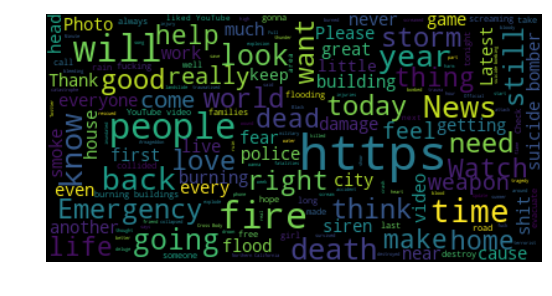

In [268]:
wordcloud = WordCloud().generate(str(doc))

wordcloud = WordCloud(max_font_size=40).generate(str(doc))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Je ne vois pas vraiment comment le Stemming ou Lemmatization pourrait être appliqué pour réduire le nombre des tokens

# Vectorisation

Si on regarde les données, on vois que les mots se répètent en fonction de leur importance dans les données.

Je vais supposer que la méthode de sac de mots sera la plus appropriée, et je vais la comparer avec d'autres méthodes de classification.

Pour les méthodes utilisées, je trouve difficile d'employer d'autres méthodes que je connais d'auparavant pour faire les analyses, et vais donc employer les outils vus en cours à la place (données principalement textuelles).

In [269]:
# Vérifions si il y a des NaN

df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [270]:
len(df)

7613

In [271]:
# On retire les NaN pour éviter de biaiser les données
df.dropna(inplace=True)

len(df)

5080

In [341]:
# Testons d'abord avec la régression logistique

X = df[['keyword','text']]
y = df['target']

# Paramètres changables pour les tests. Valeures initiales: size = 0.33 , random = 42
size = 0.40
random = 70


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=random)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)

Training Data Shape: (3048, 2)
Testing Data Shape:  (2032, 2)


In [342]:
# On entraine le modèle avec la régression logistique

from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='lbfgs')

#lr_model.fit(X_train, y_train)

In [343]:
# Testons avec une feature extraction

df['target'].value_counts()

0    2884
1    2196
Name: target, dtype: int64

In [344]:
# ~= 76.1% des tweets ne parlent pas d'accidents. Il faudra donc dépasser cette valeur en précision.
2196 / 2884

0.7614424410540915

In [345]:
# On split les données en train et test pour les entrainer:

X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=random)


# On entraine les données avec Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(3048, 11518)

In [346]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_train_tfidf.shape

(3048, 11518)

In [347]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train_tfidf,y_train)

LinearSVC()

In [348]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# On peut maintenant utiliser le pipeline pour entrainer les données.
text_clf.fit(X_train, y_train)  

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [349]:
# Formons les prédictions:
predictions = text_clf.predict(X_test)

In [350]:
# Matrice de confusion
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[931 174]
 [263 664]]


In [351]:
# Rapport de classification
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1105
           1       0.79      0.72      0.75       927

    accuracy                           0.78      2032
   macro avg       0.79      0.78      0.78      2032
weighted avg       0.79      0.78      0.78      2032



In [352]:
# Score d'accuracy trouvé:
print(metrics.accuracy_score(y_test,predictions))

0.7849409448818898


Les données renvoient un résultat suffisant pour démontrer son fonctionnement (score accuracy supérieur à la disposition des données)

In [353]:
# Faisons maintenant la classification des textes:

X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=random)


# On entraine les données avec 2 méthodes:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Naïve Bayes:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

In [354]:
# Entrainement avec les données naïves Bayes
text_clf_nb.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [355]:
# Formons les prédictions:
predictions = text_clf_nb.predict(X_test)

In [356]:
# Matrice de confusion
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[1060   45]
 [ 423  504]]


In [357]:
# Rapport de classification
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.71      0.96      0.82      1105
           1       0.92      0.54      0.68       927

    accuracy                           0.77      2032
   macro avg       0.82      0.75      0.75      2032
weighted avg       0.81      0.77      0.76      2032



In [358]:
# Score d'accuracy trouvé:
print(metrics.accuracy_score(y_test,predictions))

0.7696850393700787


In [359]:
# Entrainement avec les données SVC Linéaire
text_clf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [360]:
# Formons les prédictions:
predictions = text_clf_lsvc.predict(X_test)

In [361]:
# Matrice de confusion
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[931 174]
 [263 664]]


In [362]:
# Rapport de classification
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1105
           1       0.79      0.72      0.75       927

    accuracy                           0.78      2032
   macro avg       0.79      0.78      0.78      2032
weighted avg       0.79      0.78      0.78      2032



In [363]:
# Score d'accuracy trouvé:
print(metrics.accuracy_score(y_test,predictions))

0.7849409448818898


On retrouve une meilleure accuracy en utilisant Naïve Bayes que les autres précédents.